# ETL y EDA

## Importación de librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import gzip
import json

## 1. Dataset 'steam_games.json. gz'

### Importación de datos del dataset

In [3]:
# Importación del Dataset
# Reemplaza 'mi_archivo.json.gz' con la ruta de tu archivo
with gzip.open('dataset/steam_games.json.gz', mode='rt') as f:
    data = [json.loads(line) for line in f]

# Ponemos la variable como un DataFrame
games= pd.DataFrame(data)

### Exploración de los datos

In [4]:
games.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
games.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


In [6]:
# Cantidad de nulos por columnas
games.isnull().mean()*100

publisher       80.004982
genres          76.045498
app_name        73.321433
title           75.021794
url             73.319773
release_date    75.035909
tags            73.455104
reviews_url     73.321433
specs           73.876043
price           74.463033
early_access    73.319773
id              73.321433
developer       76.058782
dtype: float64

Se deduce que gran cantidad de los datos nulos del DataFrame afectaria considerablemente, sin embargo para esta ocasión se realizará la eliminación de los elementos nulos de manera sistematica

In [7]:
# Se eliminan las filas que no ofrecen información alguna
games.dropna(how= 'all', inplace= True)

# Registro num 88384 y 90890, en la mayoría no hay datos, podemos 
# eliminar estas filas
games.drop([88384,90890], inplace= True)

# Se puede eliminar la columna title por ser la misma a la 'app_name'
games.drop(columns= ['title'], inplace= True)

# Eliminamos las columnas que no ayudan a nuestro EDA
games.drop(columns= ['url', 'tags', 'reviews_url', 'early_access',
                     'specs'], inplace= True)


# Podemos realizar lo mismo para 'publisher' y 'developer'
condicion= games['publisher'].isnull() & games['developer'].notnull()
condicion2= games['publisher'].notnull() & games['developer'].isnull()

# Se reemplazan los valores nulos de las empresas que publicaron
# a desarrolladoras y viceversa
games.loc[condicion, 'publisher'] = games.loc[condicion, 'developer']
games.loc[condicion2, 'developer'] = games.loc[condicion2, 'publisher']

In [8]:
games.isnull().mean()*100

publisher       10.058196
genres          10.213799
app_name         0.000000
release_date     6.429527
price            4.282202
id               0.003112
developer       10.058196
dtype: float64

### Imputación de datos

Realizaremos una imputación de los valores nulos de los precios con los precios promedios de los generos que se asemejan

In [9]:
# Terminamos de eliminar el resto de elementos nulos
games.dropna(inplace=True)

In [10]:
# Se convierte la columna 'genres' para que sea hashable
games['genres']= games['genres'].apply(lambda x: tuple(x) if x is not None else x)

In [11]:
# La variable prom tendra las columnas genero y precios
prom= games.loc[:,['genres','price']]

# ponemos las variables que estan como lista a tuples para hashearlas
prom['genres']= prom['genres'].apply(lambda x: tuple(x))

# Elegimos todas los registros que tienen como variable float en la columna 'Price'
prom= prom.loc[prom['price'].apply(lambda x: not isinstance(x, str)), :]

# Se realiza la agrupación de los generos y se estima el promedio
prom['price'].astype(float)
promedio= prom.groupby('genres')['price'].mean()

# saca pone los indices en forma de columna
promedio= promedio.reset_index()
# promedio['genres'] = promedio.genres.apply(lambda x: list(x))
promedio.columns = ['genres','average price']

In [12]:
# Luego de realizar la imputación de los datos realizamos la conexion entre la tabla games y promedio y eliminamos los datos None
games= pd.merge(games, promedio, on= 'genres', how= 'left')
games['price']= games['price'].fillna(games['average price'])

# Reemplazamos los valores que son 'str' con los valores que sacamos de los promedios de la columna 'average price'
games['price'] = games.apply(lambda row: row['average price'] if isinstance(row['price'], str) else row['price'], axis=1)
games.dropna(inplace= True)

In [13]:
games['genres']= games['genres'].apply(lambda x: list(x))

### Exportación de datos

In [14]:
# Exportamos el DataFrame a archivo .parquet
games.to_parquet('steam_games.parquet')

## 2. Dataset 'user_reviews.json.gz'

### Importación los datos del dataset

In [15]:
# se crea una nueva lista en blanco para anexar los datos a esa lista
rows=[]

# con el metodo gzip, se lee el archivo .gz
with gzip.open('dataset/user_reviews.json.gz', 'rb') as f:
    for line in f.readlines():
        rows.append(ast.literal_eval(line.decode(encoding= 'utf-8')))

# lo ponemos en un DataFrame llamado "reviews"
reviews= pd.DataFrame(rows)

### Exploración de los datos

In [16]:
reviews.head(5)

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


Se ve que la columna 'reviews' tiene anidados datos en formato JSON, realizaremos su segmentación

In [17]:
# Descomponemos los datos estructurados de la lista de la columna 'reviews'
df_review_explot = reviews.explode('reviews')
# Normalizamos los datos en formato json y lo guardamos en un DataFrame
df_norm = pd.json_normalize(df_review_explot['reviews'])

In [18]:
# Iniciamos los indices desde cero
df_review_explot.reset_index(drop=True, inplace=True)
df_norm.reset_index(drop=True, inplace=True)

In [19]:
# Concatenamos los DataFrames
reviews = pd.concat([df_review_explot,df_norm], axis=1)

In [20]:
# Eliminamos la columna
reviews.drop(columns=['reviews'],inplace=True)

Cantidad de nulos en el DataFrame

In [21]:
reviews.isnull().mean()*100

user_id        0.000000
user_url       0.000000
funny          0.047191
posted         0.047191
last_edited    0.047191
item_id        0.047191
helpful        0.047191
recommend      0.047191
review         0.047191
dtype: float64

In [22]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      59333 non-null  object
 1   user_url     59333 non-null  object
 2   funny        59305 non-null  object
 3   posted       59305 non-null  object
 4   last_edited  59305 non-null  object
 5   item_id      59305 non-null  object
 6   helpful      59305 non-null  object
 7   recommend    59305 non-null  object
 8   review       59305 non-null  object
dtypes: object(9)
memory usage: 4.1+ MB


- Se realiza el borrado de todos los nulos por no ser tantos
- Eliminamos las columnas 'funny','last_edited','user_url','posted','helpful' por no contener datos relevantes para el analisis

In [23]:
# Se realiza el borrado de todos los nulos por no ser tantos
reviews.dropna(inplace=True)

In [24]:
# Eliminamos las columnas 'funny','last_edited','user_url','posted','helpful' por no contener datos relevantes para el analisis
reviews.drop(columns=['funny','last_edited','user_url','posted','helpful'],inplace=True)

In [25]:
reviews.head()

,user_id,item_id,recommend,review
0,76561197970982479,1250,True,Simple yet with great replayability. In my opi...
1,76561197970982479,22200,True,It's unique and worth a playthrough.
2,76561197970982479,43110,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,251610,True,I know what you think when you see this title ...
4,js41637,227300,True,For a simple (it's actually not all that simpl...


### Análisis de los datos

In [26]:
# Verificamos la cantidad de usuarios
usuarios_cuenta = reviews.user_id.nunique()
print('Hay',usuarios_cuenta,'usuarios')

Hay 25458 usuarios


In [27]:
# Verificamos la cantidad de items
items_cuenta = reviews.item_id.nunique()
print('Hay',items_cuenta,'items')

Hay 3682 items


In [28]:
reviews.recommend.value_counts()

recommend
True     52473
False     6832
Name: count, dtype: int64

<Axes: ylabel='recommend'>

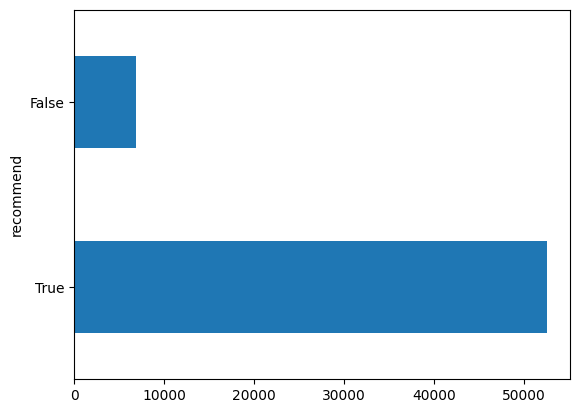

In [29]:
# Se verifica por medio de un gráfico de barras que porcentaje son los que si se recomiendan y los que no
reviews.recommend.value_counts().plot.barh()

### Exportación de datos

In [30]:
reviews.to_parquet('user_reviews.parquet')

## 3. Dataset 'users_items.json.gz' (más largo)

### Importación del dataset

In [31]:
rows=[]

with gzip.open('dataset/users_items.json.gz', 'rb') as f:
    for line in f.readlines():
        rows.append(ast.literal_eval(line.decode(encoding= 'utf-8')))

items= pd.DataFrame(rows)

### Transformación, exploración y análisis del dataset

In [32]:
df_items_explode = items.explode('items')
df_item_norm = pd.json_normalize(df_items_explode['items'])

In [33]:
df_items_explode.reset_index(drop=True, inplace=True)
df_item_norm.reset_index(drop=True, inplace=True)

In [34]:
items = pd.concat([df_items_explode,df_item_norm], axis=1)

In [35]:
items.drop(columns=['items'], inplace=True)

In [36]:
items.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0


In [37]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170015 entries, 0 to 5170014
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   items_count       int64  
 2   steam_id          object 
 3   user_url          object 
 4   item_id           object 
 5   item_name         object 
 6   playtime_forever  float64
 7   playtime_2weeks   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 315.6+ MB


In [38]:
# Cantidad de nulos por columnas
items.isnull().sum()

user_id                 0
items_count             0
steam_id                0
user_url                0
item_id             16806
item_name           16806
playtime_forever    16806
playtime_2weeks     16806
dtype: int64

In [39]:
condicion = items.playtime_forever.isnull()
items[condicion]

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
3733,Wackky,0,76561198039117046,http://steamcommunity.com/id/Wackky,NaN,NaN,NaN,NaN
3849,76561198079601835,0,76561198079601835,http://steamcommunity.com/profiles/76561198079...,NaN,NaN,NaN,NaN
6019,hellom8o,0,76561198117222320,http://steamcommunity.com/id/hellom8o,NaN,NaN,NaN,NaN
6523,starkillershadow553,0,76561198059648579,http://steamcommunity.com/id/starkillershadow553,NaN,NaN,NaN,NaN
7237,darkenkane,0,76561198058876001,http://steamcommunity.com/id/darkenkane,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5169470,76561198316380182,0,76561198316380182,http://steamcommunity.com/profiles/76561198316...,NaN,NaN,NaN,NaN
5169471,76561198316970597,0,76561198316970597,http://steamcommunity.com/profiles/76561198316...,NaN,NaN,NaN,NaN
5169472,76561198318100691,0,76561198318100691,http://steamcommunity.com/profiles/76561198318...,NaN,NaN,NaN,NaN
5170006,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,NaN,NaN,NaN,NaN


- Se ve que hay una cantidad pequeña de nulos en comparación del tamaño del dataset, se procederá a eliminar los nulos.
- Eliminamos las columnas que no seran relevantes para nuestro analisis en este caso serán 'user_url'

In [40]:
# eliminamos nulos, columna innecesaria y reseteamos los indices
items.dropna(inplace=True)
items.drop(columns=['user_url'],inplace=True)
items.reset_index(drop=True, inplace=True)

In [41]:
# Vemos si la columna 'user_id' podria ser la misma que 'steam_id' para eliminar alguna de ellas
(items.user_id == items.steam_id).value_counts()

# Pero no son iguales

False    2950877
True     2202332
Name: count, dtype: int64

In [42]:
items.shape

(5153209, 7)

### Exportación del dataset

In [43]:
items.to_parquet('users_items.parquet')